<a href="https://colab.research.google.com/github/faizanali02/googlecolab/blob/main/AI_A01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Metrics: {'pct_in_band': np.float64(2.5), 'avg_water_per_step': np.float64(0.0), 'avg_abs_dev': np.float64(0.41758168205938756), 'over_events': 0, 'under_events': 234, 'avg_utility': -14.817882168857262, 'total_water': 0.0}


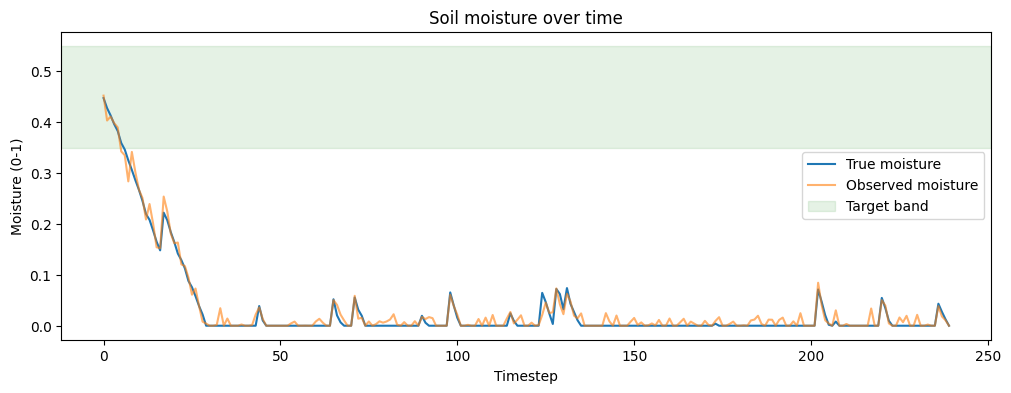

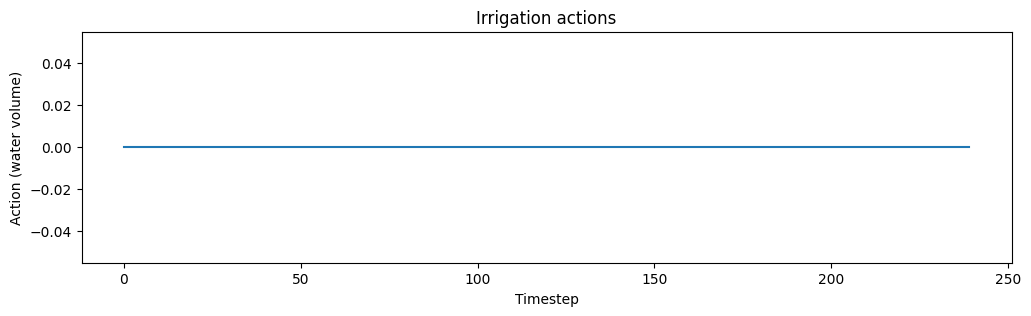

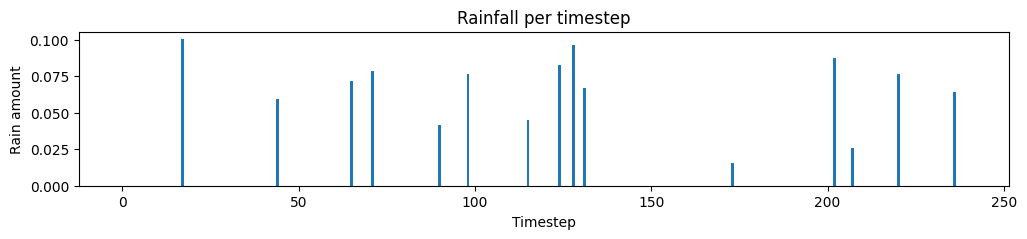

In [1]:
# Colab-ready: Smart Farming Irrigation - Utility-based Agent
# Paste into a single Colab cell or split logically across cells.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import random

# -------------------------
# Environment: simple soil moisture model
# -------------------------
class IrrigationEnv:
    """
    Simulates one patch of soil moisture (relative scale 0..1).
    Dynamics (per timestep):
      moisture_next = moisture + inflow - evap + rainfall_noise
    Inflow = irrigation_action_volume * irrigation_efficiency
    Evap = base_evapotranspiration * vegetation_factor (can vary with day)
    Rainfall: stochastic
    """
    def __init__(self,
                 init_moisture=0.3,
                 soil_capacity=1.0,
                 field_capacity=0.6,
                 wilting_point=0.15,
                 evap_base=0.02,
                 evap_var=0.01,
                 rain_prob=0.05,
                 rain_amount_mean=0.08,
                 sensor_noise=0.01,
                 seed=None):
        self.rng = np.random.RandomState(seed)
        self.soil_capacity = soil_capacity
        self.field_capacity = field_capacity
        self.wilting_point = wilting_point
        self.evap_base = evap_base
        self.evap_var = evap_var
        self.rain_prob = rain_prob
        self.rain_amount_mean = rain_amount_mean
        self.sensor_noise = sensor_noise
        self.moisture = np.clip(init_moisture, 0.0, soil_capacity)
        self.time = 0

    def step(self, action_volume):
        """
        action_volume: water added this timestep (liters-per-area equivalent normalized to [0,1])
        Returns: observation (noisy moisture), reward components dict, info
        """
        # Rain
        rain = 0.0
        if self.rng.rand() < self.rain_prob:
            rain = max(0.0, self.rng.normal(self.rain_amount_mean, self.rain_amount_mean * 0.5))

        # Evapotranspiration (ET)
        evap = max(0.0, self.rng.normal(self.evap_base, self.evap_var))

        # Inflow from irrigation (efficiency factor)
        efficiency = 0.85  # fraction reaching root zone
        inflow = action_volume * efficiency

        # Update moisture
        self.moisture = self.moisture + inflow + rain - evap
        # clamp
        self.moisture = float(np.clip(self.moisture, 0.0, self.soil_capacity))

        # Observation with noise
        obs = self.moisture + self.rng.normal(0.0, self.sensor_noise)
        obs = float(np.clip(obs, 0.0, self.soil_capacity))

        # Info for logging
        info = {'rain': rain, 'evap': evap, 'inflow': inflow}
        self.time += 1
        return obs, info

    def reset(self, init_moisture=None):
        if init_moisture is None:
            self.moisture = np.clip(self.rng.uniform(self.wilting_point, self.field_capacity), 0.0, self.soil_capacity)
        else:
            self.moisture = np.clip(init_moisture, 0.0, self.soil_capacity)
        self.time = 0
        obs = self.moisture + self.rng.normal(0.0, self.sensor_noise)
        return float(np.clip(obs, 0.0, self.soil_capacity))

# -------------------------
# Utility-based agent
# -------------------------
@dataclass
class UtilityIrrigationAgent:
    target_low: float = 0.35
    target_high: float = 0.6
    max_action: float = 0.12  # maximum normalized water per timestep (e.g., high)
    action_levels: list = field(default_factory=lambda: [0.0, 0.04, 0.08, 0.12])  # OFF, LOW, MED, HIGH
    water_cost_coeff: float = 1.0  # penalty per unit water
    dev_penalty_coeff: float = 10.0  # penalty per unit absolute deviation from target
    over_penalty_coeff: float = 5.0  # extra penalty for exceeding soil_capacity (rare due to clipping)
    model_evap_estimate: float = 0.02
    model_efficiency: float = 0.85
    rng_seed: int = None

    def __post_init__(self):
        self.rng = np.random.RandomState(self.rng_seed)

    def estimate_state(self, obs):
        # Simple filter: trust obs with small smoothing
        # For demo, return obs directly (could implement a Kalman filter)
        return obs

    def predict_next_moisture(self, current_moisture, action_volume, expected_rain=0.0):
        """
        Predict next moisture using simple deterministic model:
        next = current + efficiency*action - evap + expected_rain
        """
        evap = self.model_evap_estimate
        inflow = action_volume * self.model_efficiency
        return float(np.clip(current_moisture + inflow + expected_rain - evap, 0.0, 1.0))

    def utility(self, predicted_moisture, action_volume):
        """
        Utility is high when predicted_moisture inside [target_low, target_high],
        penalize distance from midpoint and penalize water usage.
        """
        # Reward for closeness to target band (we prefer inside band)
        mid = (self.target_low + self.target_high) / 2.0
        dev = abs(predicted_moisture - mid)
        dev_pen = self.dev_penalty_coeff * dev

        # Extra penalty if outside band (steeper)
        if predicted_moisture < self.target_low:
            dev_pen += (self.target_low - predicted_moisture) * (self.dev_penalty_coeff)
        elif predicted_moisture > self.target_high:
            dev_pen += (predicted_moisture - self.target_high) * (self.over_penalty_coeff)

        water_pen = self.water_cost_coeff * action_volume

        # Total utility (higher is better) -> negative costs
        return - (dev_pen + water_pen)

    def select_action(self, estimated_moisture, rain_forecast_expected=0.0):
        # Evaluate expected utility for each discrete action
        best_u = -1e9
        best_a = 0.0
        for a in self.action_levels:
            pred = self.predict_next_moisture(estimated_moisture, a, expected_rain=rain_forecast_expected)
            u = self.utility(pred, a)
            if u > best_u:
                best_u = u
                best_a = a
        return best_a, best_u

# -------------------------
# Experiment runner + evaluation
# -------------------------
def run_episode(env, agent, steps=240, verbose=False, rain_forecast_policy=None):
    """
    Runs one episode of given length.
    rain_forecast_policy: function(env) -> expected_rain (optional)
    Returns logs (DataFrame).
    """
    obs = env.reset()
    estimated = agent.estimate_state(obs)
    records = []
    total_water = 0.0
    for t in range(steps):
        # Optionally use a forecast: here we use expected rain probability * mean
        if rain_forecast_policy:
            expected_rain = rain_forecast_policy(env)
        else:
            expected_rain = 0.0

        action_volume, util = agent.select_action(estimated, rain_forecast_expected=expected_rain)
        # Execute
        obs, info = env.step(action_volume)
        estimated = agent.estimate_state(obs)

        # Logging
        rec = {
            't': t,
            'obs': obs,
            'true_moisture': env.moisture,
            'action': action_volume,
            'utility': util,
            'rain': info['rain'],
            'evap': info['evap'],
            'inflow': info['inflow']
        }
        total_water += action_volume
        records.append(rec)
        if verbose and (t % 24 == 0):
            print(f"t={t} obs={obs:.3f} action={action_volume:.3f} rain={info['rain']:.3f}")
    df = pd.DataFrame(records)
    metrics = compute_metrics(df, agent)
    metrics['total_water'] = total_water
    return df, metrics

def compute_metrics(df, agent):
    # % timesteps within target band
    in_band = df['true_moisture'].between(agent.target_low, agent.target_high)
    pct_in_band = 100.0 * in_band.sum() / len(df)
    avg_water = df['action'].mean()
    avg_dev = (abs(df['true_moisture'] - (agent.target_low+agent.target_high)/2)).mean()
    over_events = (df['true_moisture'] > agent.target_high).sum()
    under_events = (df['true_moisture'] < agent.target_low).sum()
    avg_utility = df['utility'].mean()
    return {
        'pct_in_band': pct_in_band,
        'avg_water_per_step': avg_water,
        'avg_abs_dev': avg_dev,
        'over_events': int(over_events),
        'under_events': int(under_events),
        'avg_utility': float(avg_utility)
    }

# -------------------------
# Example usage: run multiple episodes and plot
# -------------------------
def main_experiment(seed=42):
    env = IrrigationEnv(init_moisture=0.3, seed=seed,
                        evap_base=0.02, evap_var=0.005,
                        rain_prob=0.08, rain_amount_mean=0.07,
                        sensor_noise=0.015)
    agent = UtilityIrrigationAgent(target_low=0.35, target_high=0.55,
                                  action_levels=[0.0, 0.03, 0.06, 0.12],
                                  water_cost_coeff=40.0,  # scale to make water expensive
                                  dev_penalty_coeff=20.0,
                                  model_evap_estimate=0.02,
                                  model_efficiency=0.85,
                                  rng_seed=seed)

    # Optional simple rain forecast policy: expect probability * mean_amount
    def forecast(env):
        return env.rng.rand() * env.rain_amount_mean * env.rain_prob  # simple, conservative

    df, metrics = run_episode(env, agent, steps=240, verbose=False, rain_forecast_policy=forecast)
    print("Metrics:", metrics)

    # Plot
    plt.figure(figsize=(12,4))
    plt.plot(df['t'], df['true_moisture'], label='True moisture')
    plt.plot(df['t'], df['obs'], label='Observed moisture', alpha=0.6)
    plt.axhspan(agent.target_low, agent.target_high, color='green', alpha=0.1, label='Target band')
    plt.ylabel('Moisture (0-1)')
    plt.xlabel('Timestep')
    plt.legend()
    plt.title('Soil moisture over time')

    # Plot actions
    plt.figure(figsize=(12,3))
    plt.step(df['t'], df['action'], where='post')
    plt.xlabel('Timestep')
    plt.ylabel('Action (water volume)')
    plt.title('Irrigation actions')

    # Plot rain events
    plt.figure(figsize=(12,2))
    plt.bar(df['t'], df['rain'])
    plt.title('Rainfall per timestep')
    plt.xlabel('Timestep')
    plt.ylabel('Rain amount')
    plt.show()

    return df, metrics

# Run experiment
if __name__ == "__main__":
    df, metrics = main_experiment(seed=123)
